# Tutorial 5: FEM for an Euler-Bernoulli beam
In this tutorial we will use the FEM to solve a simple Euler-Bernoulli (EB) beam. We recall that the equation of motion of an EB beam is given by the following PDE:

$$ \rho A \frac{\partial^2 u(x,t)}{\partial t^2} + E I \frac{\partial^4 u(x,t)}{\partial x^4} = q(x) $$

We consider that the beam has the following properties:

* Length of $ L = 3$ m
* Clamped at $ x = 0 $, that means $ u(0,t) = 0 $ and $ u'(0,t) = 0 \quad \forall t $
* The rod is at rest initially,  $ u(x,0) = 0$ and $ \dot{u}(x,0) = 0 $
* A dynamic distributed load $ q(x,t) = 1e-3(L-x)+1e3sin(2\pi t) $ $N/m$ is applied
* $\rho = 8e3$ $kg/m^3$
* $A = 0.01$ $m^2$
* $E = 2.1e9$ $Pa$
* $ I = 2e-5$ $m^4$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L = 3           # [m]
u0 = 0          # [m]
u0_dt2 = 0      # [m/s^2]
du0 = 0         # [m]
du0_dt2 = 0     # [m/s^2]
def pressure(x, t):
    return 1e-3*(L - x) + 1e3*np.sin(2*np.pi*t)
rho = 8e3       # [kg/m^3]
A = 1e-2        # [m^2]
E = 2.1e9       # [Pa]
I = 2e-5        # [m^4]

## Step 1: discretize the domain

We consider a discretization made out of $n_c = 5$ elements equally spaced.

In [2]:
ne = 5
nn = ne + 1
ndofs = 2*nn
xn = np.linspace(0, L, nn)

With the corresponding element-DOFs and DOF-node connectivity.

In [3]:
elem_dofs = []
dof_node = []
for ie in np.arange(0, ne):
    elem_dofs.append(np.arange(2*ie, 2*ie + 4))
for idof in np.arange(0, ndofs):
    dof_node.append(int(np.floor(idof/2)))

## Step 2: define the shape functions

Here we assume that the displacement can be well captured by a piece-wise cubic function, so we make the modelling choice of selecting cubic shape functions.

$$ N(x) = a + bx + cx^2 + dx^3 $$

In that case, for each element, we need 4 DOFs to generate a cubic shape function. And we want to enforce that the shape functions associated to each DOF is 2 where the DOF is loacted and 0 otherwise.

In theory, we have seen that we can obtain the coefficients by solving a linear system of the type:

$$\begin{bmatrix} 1 & x_l & x_l^2 & x_l^3 \\ 0 & 1 & 2x_l & 3x_l^2 \\ 1 & x_r & x_r^2 & x_r^3 \\ 0 & 1 & 2x_r & 3x_r^2 \end{bmatrix} \begin{bmatrix} a \\ b \\ c \\ d \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix} $$

Here, assuming that all elements have the same size $h$, we will simplify the system taking $x_l=0$ and $x_r=h$. Then, we can compute the shape functions associated to the 4 DOFs as follows

In [4]:
N_k = []
dN_k = []
ddN_k = []
h = L/ne
matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [1, h,  h**2, h**3], [0, 1, 2*h, 3*h**2]])

def base(x):
    if isinstance(x, float):
        return np.array([[1], [x], [x**2], [x**3]])
    else:
        return np.array([[np.ones(len(x))], [x], [x**2], [x**3]])
def dbase(x):
    if isinstance(x, float):
        return np.array([[0], [1], [2*x], [3*x**2]])
    else:
        return np.array([[np.zeros(len(x))], [np.ones(len(x))], [2*x], [3*x**2]])
def ddbase(x):
    if isinstance(x, float):
        return np.array([[0], [0], [2], [6*x]])
    else:
        return np.array([[np.zeros(len(x))], [np.zeros(len(x))], [2*np.ones(len(x))], [6*x]])
def make_N(coeff): 
    return lambda x: np.dot(np.transpose(base(x)), coeff)
def make_dN(coeff):
    return lambda x: np.dot(np.transpose(dbase(x)), coeff)
def make_ddN(coeff):
    return lambda x: np.dot(np.transpose(ddbase(x)), coeff)

dof_vec = np.arange(0,4)
for idof in dof_vec:
    rhs = np.zeros(len(dof_vec))
    rhs[idof] = 1
    coeff = np.linalg.solve(matrix, rhs)
    N_k.append(make_N(coeff))
    dN_k.append(make_dN(coeff))
    ddN_k.append(make_ddN(coeff))


Let's see how these functions look like for an element and check that they satisfy the requirements:

* For DOF 1 we want: $N_1(0) = 1.0$, $N_1(h)=0.0$ and $N_1'(0)=N_1'(h)=0.0$.
* For DOF 2 we want: $N_2(0)=N_2(h)=0.0$, $N_2'(0)=1.0$ and $N_2'(h) = 0.0$.
* For DOF 3 we want: $N_3(0) = 0.0$, $N_3(h) = 1.0$ and $N_3'(0) = N_3'(h) = 0.0$.
* For DOF 4 we want: $N_4(0) = N_4(h) = 0.0$, $N_4'(0) = 1.0$ and $N_4'(h) = 0.0$.

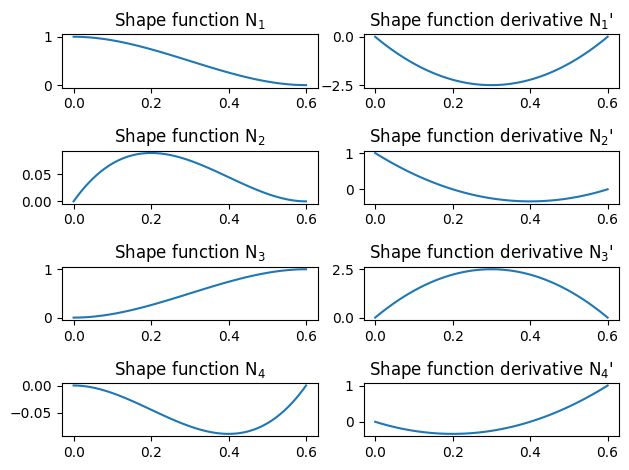

In [5]:
xplot = np.arange(0, h + h/100, h/100)

fig, axs = plt.subplots(4, 2)
axs[0, 0].plot(xplot, N_k[0](xplot))
axs[0, 0].set_title("Shape function N$_1$")
axs[0, 1].plot(xplot, dN_k[0](xplot))
axs[0, 1].set_title("Shape function derivative N$_1$'")
axs[1, 0].plot(xplot, N_k[1](xplot))
axs[1, 0].set_title("Shape function N$_2$")
axs[1, 1].plot(xplot, dN_k[1](xplot))
axs[1, 1].set_title("Shape function derivative N$_2$'")
axs[2, 0].plot(xplot, N_k[2](xplot))
axs[2, 0].set_title("Shape function N$_3$")
axs[2, 1].plot(xplot, dN_k[2](xplot))
axs[2, 1].set_title("Shape function derivative N$_3$'")
axs[3, 0].plot(xplot, N_k[3](xplot))
axs[3, 0].set_title("Shape function N$_4$")
axs[3, 1].plot(xplot, dN_k[3](xplot))
axs[3, 1].set_title("Shape function derivative N$_4$'")

# automatically fix subplot spacing
plt.tight_layout()

## Step 3: computation of the elemental matrices

In the theory we have seen that the mass and stiffness matrices for the EB beam problem can be computed as:

$$ M_{i,j}^k = \int_{x_a}^{x_b} \rho A N_i^k(x)N_j^k(x)dx, $$

$$ K_{i,j}^k = \int_{x_a}^{x_b} E I N_i''^k(x)N_j''^k(x)dx. $$

Here we call the auxiliar function `elemental_matrices(P)` with `P` being a variable containting all the parameters.

In [6]:
import scipy.integrate as scp
M_k = np.zeros((4, 4))
K_k = np.zeros((4, 4))
for idof in np.arange(0, 4):
    for jdof in np.arange(0, 4):
        def eqn_M(x):
            return rho*A*N_k[idof](x)*N_k[jdof](x)
        def eqn_K(x): 
            return E*I*ddN_k[idof](x)*ddN_k[jdof](x) +1*N_k[idof](x)*N_k[jdof](x)
        M_k[idof, jdof] = scp.quad(eqn_M, 0, h)[0]
        K_k[idof, jdof] = scp.quad(eqn_K, 0, h)[0]

-----------------------------------------------------------------------------------------------------
**Problem**: Implement directly the elemental matrices given in the theory and compare with the ones computed here.

-----------------------------------------------------------------------------------------------------

In this example we also have a distributed dynamic loading function. This will give us a contribution to the right-hand-side vector that reads:

$$ Q_i^k = \int_{x_a}^{x_b} q(x)N_i(x)dx $$

Since we want to integrate a multi-variable function $q(x,t)$ over one variable only $x$, we will use a symbolic integral here. Note that in that case, $q(x)$ is not the same for all elements, so we'll have to store all the elemental contributions.

In [7]:
# Implement directly here ...
# eqn = q

In [8]:
# # def make_Q(eqn, xe):
# #     return lambda t: scp.quad(eqn, xe[0], xe[1], args=(1,))[0]

# def make_Q(eqn, xe):
#     return scp.quad(eqn, xe[0], xe[1])[0]

# Q2_k = []
# for ie in np.arange(0, ne):
#     dofs = elem_dofs[ie]
#     nodes = [dof_node[dofs[0]], dof_node[dofs[-1]]]
#     xe = xn[nodes]
#     Q_k = []
#     for idof in np.arange(0, 4):
#         def eqn1(x): 
#             return (1e-3*(L-x))*N_k[idof](x)
#         def eqn2(x):
#             return 1e3*N_k[idof](x)
#         def make_Q1():
#             return lambda t: [make_Q(eqn1, xe), make_Q(eqn2, xe)]
#         #Q_k.append([make_Q(eqn1, xe), make_Q(eqn2, xe)])
#         Q_k.append(make_Q1())
#     Q2_k.append(Q_k)


## Step 4: global assembly

To construct the global matrices we add all the elemental contributions to the corresponding nodes.

In [9]:
# K = np.zeros((ndofs*ndofs))       # 1-D array for global stiffness matrix
# M = np.zeros((ndofs*ndofs))       # 1-D array for global mass matrix
# Q = np.zeros(ndofs)              # 1-D array for Q vector

# for ie in np.arange(0, ne):
#     # Get the nodes of the elements
#     dofs = elem_dofs[ie]
#     NodeLeft = dof_node[dofs[0]]
#     NodeRight = dof_node[dofs[-1]]
    
#     # Get the degrees of freedom that correspond to each node
#     Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
#     Dofs_Right = 2*(NodeRight) + np.arange(0, 2)

#     # Assemble the matrices at the correct place
#     nodes = np.append(Dofs_Left, Dofs_Right)
#     for i in np.arange(0, 4):
#         Q[nodes[i]] = Q[nodes[i]] + Q2_k[ie][i]
#         for j in np.arange(0, 4):
#             ij = nodes[j] + nodes[i]*ndofs
#             M[ij] = M[ij] + M_k[i, j]
#             K[ij] = K[ij] + K_k[i, j]
            
# # Reshape the global matrix from a 1-D array to a 2-D array
# M = M.reshape((ndofs, ndofs))
# K = K.reshape((ndofs, ndofs))

# # Transform the Q vector into functions dependent on time
# Q_vector = []
# for i in np.arange(0, ndofs):
#     Q_vector.append(lambda t: Q[i] + 0.0*t)

In [10]:
K = np.zeros((ndofs*ndofs))       # 1-D array for global stiffness matrix
M = np.zeros((ndofs*ndofs))       # 1-D array for global mass matrix

for ie in np.arange(0, ne):
    # Get the nodes of the elements
    dofs = elem_dofs[ie]
    NodeLeft = dof_node[dofs[0]]
    NodeRight = dof_node[dofs[-1]]
    
    # Get the degrees of freedom that correspond to each node
    Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
    Dofs_Right = 2*(NodeRight) + np.arange(0, 2)

    # Assemble the matrices at the correct place
    nodes = np.append(Dofs_Left, Dofs_Right)
    for i in np.arange(0, 4):
        for j in np.arange(0, 4):
            ij = nodes[j] + nodes[i]*ndofs
            M[ij] = M[ij] + M_k[i, j]
            K[ij] = K[ij] + K_k[i, j]
            
# Reshape the global matrix from a 1-D array to a 2-D array
M = M.reshape((ndofs, ndofs))
K = K.reshape((ndofs, ndofs))

In [11]:
def Qassembly(t, q):
    
    eqn = pressure #fun(x,t,y,z)

    Q2_k = []  # large vector
    for ie in np.arange(0, ne):
        dofs = elem_dofs[ie]
        nodes = [dof_node[dofs[0]], dof_node[dofs[-1]]]
        xe = xn[nodes]
        z = q[4*ie+1] # Vertical DOF is second entry of each smaller vector
        Q_k = [] # small vector
        for idof in np.arange(0, 4):
            Q_k.append(scp.quad(eqn, xe[0], xe[1], args=(t))[0]) # y = 0 does not matter
        Q2_k.append(Q_k)
    
    # ---------------------------------------------------------------------------------------------
    
    Q = np.zeros(ndofs)              # 1-D array for Q vector

    for ie in np.arange(0, ne):
        # Get the nodes of the elements
        dofs = elem_dofs[ie]
        NodeLeft = dof_node[dofs[0]]
        NodeRight = dof_node[dofs[-1]]

        # Get the degrees of freedom that correspond to each node
        Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
        Dofs_Right = 2*(NodeRight) + np.arange(0, 2)

        # Assemble the matrices at the correct place
        nodes = np.append(Dofs_Left, Dofs_Right)
        for i in np.arange(0, 4):
            Q[nodes[i]] = Q[nodes[i]] + Q2_k[ie][i]
    
    return Q # See lower for fx definition

In [12]:
# Q_vector

We can use the `spy` command from the MatPlotLib.PyPlot package and inspect the structure of the matrices. Since the nodes are only attached to two elements at each side, we will only have contributions from the neighbour nodes. Therefore, you see that the matrices have a tri-block-diagonal structure.

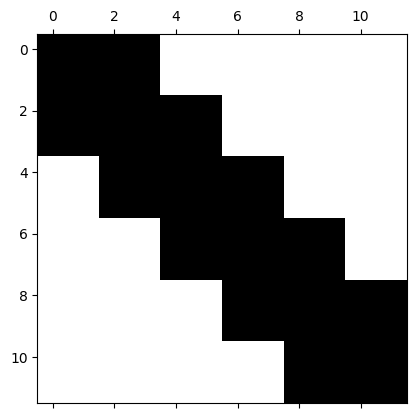

In [13]:
plt.figure()
plt.spy(M);

To apply the boundary conditions, we will remove the rows associated to the fixed DOFs and add the contribution to the right-hand-side. First, we identify the free and fixed DOFs.

In [14]:
fixed_dofs = np.arange(0, 2)                    # fixed DOFs
free_dofs = np.arange(0, ndofs)                 # free DOFs
free_dofs = np.delete(free_dofs, fixed_dofs)    # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = free_dofs[:, np.newaxis]
fy = free_dofs[np.newaxis, :]
bx = fixed_dofs[:, np.newaxis]
by = fixed_dofs[np.newaxis, :]

We can re-order the matrices and vectors in blocks, such that it's easy to operate with the blocks corresponding with the fixed DOFs. We'll use the notation $_I$ to designate an interior DOF and $_B$ to designate a boundary node.

$$ \begin{bmatrix} \bold{M}_{II} & \bold{M}_{IB} \\ \bold{M}_{BI} &\bold{M}_{BB} \end{bmatrix}, \quad \begin{bmatrix} \bold{K}_{II} & \bold{K}_{IB} \\ \bold{K}_{BI} &\bold{K}_{BB} \end{bmatrix}, \quad \begin{bmatrix} \bold{Q}_{I}  \\ \bold{Q}_{B}  \end{bmatrix} $$

In [15]:
# Mass
Mii = M[fx, fy]
Mib = M[fx, by]
Mbi = M[bx, fy]
Mbb = M[bx, by]

# Stiffness
Kii = K[fx, fy]
Kib = K[fx, by]
Kbi = K[bx, fy]
Kbb = K[bx, by]

Now operating with the different blocks, we can get a system of ODEs for the free DOFs, which is given by:

$$ \bold{M}_{II}\bold{\ddot{u}}_I + \bold{K}_{II} \bold{u}_I = \bold{Q}_I - \bold{M}_{IB}\bold{\ddot{u}}_B - \bold{K}_{IB} \bold{u}_B $$

In [16]:
ub = np.array([u0, du0])
ub_dt2 = np.array([u0_dt2, du0_dt2])
RHS = -np.dot(Mib, ub_dt2) - np.dot(Kib, ub)

## Step 5: solving the ODE

At this point we have all the information to solve the ODE for each DOF. We can use what we learned in the previous modules.

In [21]:
# Construct a matrix to reshape Q 
R = np.identity(ndofs)
R = R[fx, 0:ndofs]

# Set Dimensions and initial conditions of state vector
nfdofs = len(free_dofs)
udofs = np.arange(0, nfdofs)
vdofs = np.arange(nfdofs, 2*nfdofs)
q0 = np.zeros((2*nfdofs))

# Time span (output purposes)
tf = 50
tspan = np.arange(0, tf, 1e-3)

# Solve
def odefun(t, q):
    return np.append(q[vdofs], np.linalg.solve(Mii, np.transpose(np.dot(R, Qassembly(t,q)).reshape(1,-1) 
                                                                 + RHS - np.dot(Kii, q0[udofs])))).tolist()

sol = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=q0, t_eval=tspan)  

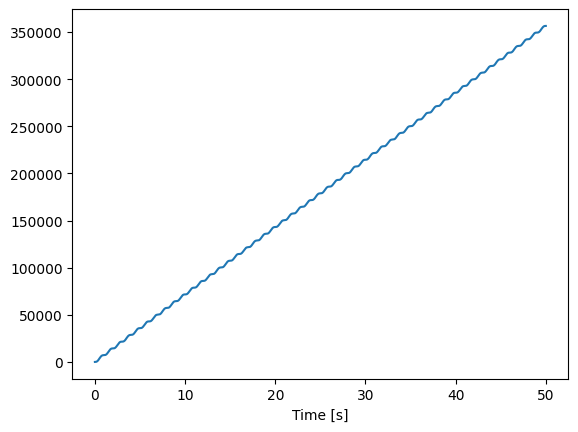

In [23]:
# Plot results
plt.figure()
plt.plot(sol.t,sol.y[int(len(sol.y)/2-1)])
#plt.ylim((-10,1))
plt.xlabel('Time [s]');

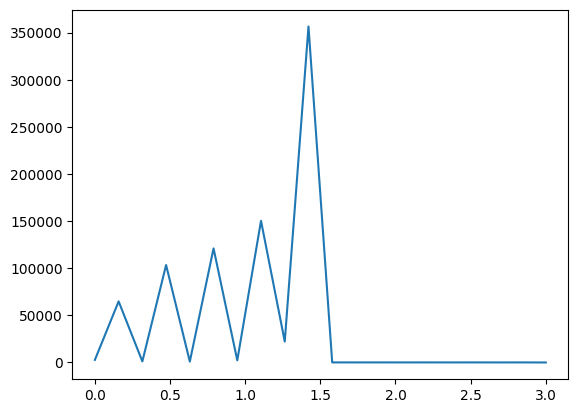

In [26]:
x = np.linspace(0,L,len(sol.y))
deflec_t = [sol.y[i][-1] for i in range(len(sol.y))] # solution at time t over beam
plt.plot(x,deflec_t)

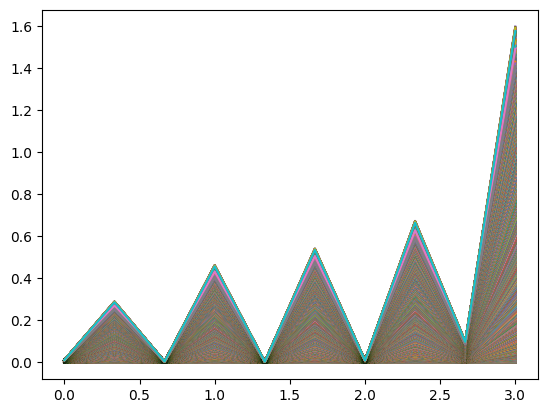

In [28]:
for j in range(len(sol.t)):
    x = np.linspace(0,L,int(len(sol.y)/2))
    deflec_t = [sol.y[i][j] for i in range(int(len(sol.y)/2))] # solution at time t over beam
    plt.plot(x,deflec_t/np.max(sol.y)*np.random.uniform(1.4,1.6))